In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from cycler import cycler

def Spec2intPower(spec):
    linSpec = 10**(spec/10)
    return 10*np.log10(np.sum(linSpec))

def decode_csv2df(csvfile):
    data = pd.read_csv(csvfile,header=None)
    filename = data[1][0]
    RefLevel = pd.to_numeric(data[1][3])
    RefOffset = pd.to_numeric(data[3][3])
    Fcenter = pd.to_numeric(data[5][3])
    Fspan = pd.to_numeric(data[7][3])
    rbw = pd.to_numeric(data[1][5])
    rbwvbwratio = 1
    vbw = rbwvbwratio*rbw
    tsweep = pd.to_numeric(data[1][6])
    freqs = pd.to_numeric(data[18:479][0].values)
    Spectra = pd.to_numeric(data[18:479][1].values)
    pol = filename.split('\\')[2].split('_')[0]
    IntPower = Spec2intPower(Spectra)
    MaxPower = np.max(Spectra)
    MinPower = np.min(Spectra)
    MedianPower = np.median(Spectra) 
    if pol == 'C3':
        poln = 'X'
    elif pol == 'C6':
        poln = 'Y'
    location = filename.split('\\')[2].split('_')[1].split('.')[0]
    return {'location': location, 'Pol': poln, 'RBW': rbw, 'VBW': vbw, 'Frequency' :freqs, 'Power': Spectra, 'IntPower': IntPower, 'MaxPower': MaxPower, 'MinPower': MinPower, 'MedianPower':MedianPower}

def plot_spectral_heatmap(
    X,
    freq,
    loc_labels,
    violin_color='blue',
    fig_size=(24, 7),
    vmin=-110,
    vmax=-85
):
    """
    Create heatmap + bottom line plot + right violin summary.
    
    Parameters
    ----------
    X : ndarray (M x K)
        Power data (locations x frequency bins)
    
    freq : ndarray (K,)
        Frequency array (Hz)
    
    loc_labels : list[str]
        Labels for each location (M entries)
    
    violin_color : str or tuple
        Color used for violin patches
    
    fig_size : tuple
        Figure size (width, height)
    
    vmin, vmax : float
        Color limits for the heatmap
    
    Cleaned code based on cell produced by ChatGPT.
    """

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    import matplotlib.cm as cm
    import numpy as np
    from cycler import cycler

    M, K = X.shape

    fig = plt.figure(figsize=fig_size)
    gs = GridSpec(3, 3, left=0.5, right=0.98, hspace=0.05, wspace=0.02)

    # Colormap for line plots
    cmap = cm.get_cmap('tab20')
    colors = [cmap(x) for x in np.linspace(0, 1, M)]

    # Axes
    ax1 = fig.add_subplot(gs[:-1, :-1])
    ax2 = fig.add_subplot(gs[-1, :-1], sharex=ax1)
    ax3 = fig.add_subplot(gs[:-1, -1], sharey=ax1)

    # 1) Heatmap
    im = ax1.imshow(
        X,
        aspect='auto',
        cmap='hot',
        interpolation='none',
        vmin=vmin,
        vmax=vmax
    )
    ax1.set_yticks(np.arange(M))
    ax1.set_yticklabels(loc_labels)
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax1.set_ylabel('Locations')
    #ax1.set_title('X-Pol/3mm/EW')

    # 2) Bottom trace plot
    ax2.set_prop_cycle(cycler(color=colors))

    ax2.plot(X.T, alpha=0.5,label=loc_labels)
    ax2.plot(X.mean(axis=0), color='k', lw=2, label='mean')

    sel = np.arange(0, K, 25)
    ax2.set_xticks(sel)
    ax2.set_xticklabels((freq[sel]/1e6).round(2), rotation=45)

    ax2.set_xlabel('Frequency (MHz)')
    ax2.set_ylabel('Power (dBm)')
    ax2.legend(bbox_to_anchor=(1.05,0.8),ncols=3)

    # 3) Violin plot on the right
    viol = ax3.violinplot(
        X.T,
        positions=np.arange(M),
        vert=False,
        widths=0.8,
        showmedians=True
    )

    # --- Apply violin color ---
    for b in viol['bodies']:
        b.set_facecolor(violin_color)
        b.set_edgecolor(violin_color)
        b.set_alpha(0.3)
    if 'cmedians' in viol:
        viol['cmedians'].set_color('black')

    ax3.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax3.set_xlabel('Power (dBm)')

    return fig, (ax1, ax2, ax3)


In [168]:
# get all csv files 
filelist = glob.glob('/home/mugundhan/iitk/Work/proposals/RadioCR_ARG/radio_cr/rfi_data/csv/*.CSV')
# open one single file to get the required headers
#data = pd.read_csv(filelist[0],header=None)
filelist.sort()
spec_v_loc = []
for csv_file in filelist[1:]:
     data_dict = decode_csv2df(csvfile=csv_file)
     spec_v_loc.append(data_dict)

# Convert to Data Frame
df = pd.DataFrame(spec_v_loc)
# Extract Frequency
Frequency = df['Frequency'][0]
# Extract Data corresponding to 'X' Polarization -- makes life easier
XPolData = df[df['Pol']=='X']
XPolPwr = np.array(XPolData['Power'].to_list())
XPolLocations = XPolData['location']
# Extract Data corresponding to 'Y' Polarization
YPolData = df[df['Pol']=='Y']
YPolPwr = np.array(YPolData['Power'].to_list())
YPolLocations = YPolData['location']

/tmp/ipykernel_384154/820232363.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', N)   # or 'viridis', 'plasma', 'turbo', etc.


Text(0.5, 0, 'Power (dBm)')

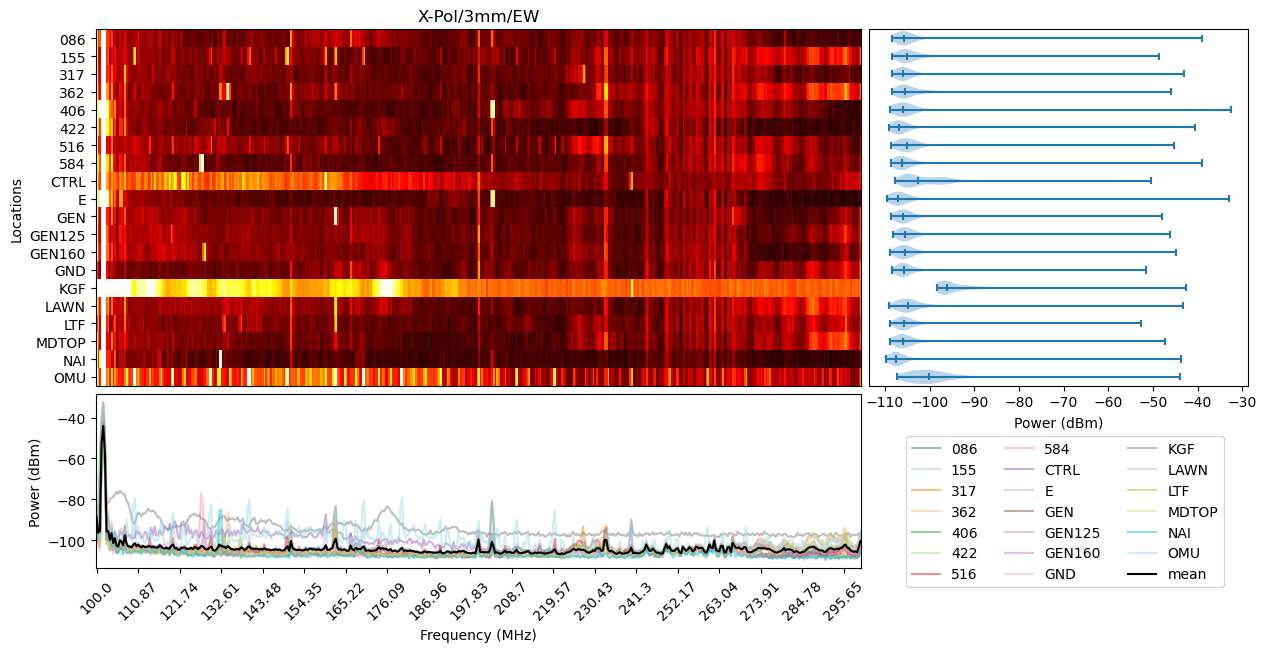

In [204]:
fig = plt.figure(figsize=(24,7))
gs = GridSpec(
    3, 3,
    left=0.5, right=0.98,
    hspace=0.05,
)

N = XPolPwr.shape[0]     # number of traces (20 in your case)
cmap = cm.get_cmap('tab20', N)   # or 'viridis', 'plasma', 'turbo', etc.
colors = [cmap(x) for x in np.linspace(0, 1, N)]
#colors = [cmap(i) for i in range(N)]   # build a shared list
gs.update(wspace=0.02)
ax1 = fig.add_subplot(gs[:-1,:-1])
ax2 = fig.add_subplot(gs[-1,:-1],sharex=ax1)
#ax2.set_prop_cycle(cycler('color', [cmap(i) for i in range(N)]))
ax2.set_prop_cycle(cycler(color=colors))

ax3 = fig.add_subplot(gs[:-1,-1],sharey=ax1)
#ax3.set_prop_cycle(cycler('color', [cmap(i) for i in range(N)]))
#ax3.set_prop_cycle(cycler(color=colors))
#ax2 = ax1.twinx()
#ax3 = ax1.twiny()
#sns.heatmap(XPolPwr,xticklabels=Frequency/10**6,yticklabels=XPolLocations,vmin=-110,vmax=-85,cmap='hot',ax=ax1,cbar_kws={'location':'top'})
ax1.imshow(XPolPwr,aspect='auto',cmap='hot',interpolation='None',vmin=-110,vmax=-85)
#ax1.set_xlabel('Frequency (MHz)')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.set_yticks(np.arange(len(XPolLocations)))
ax1.set_yticklabels(XPolLocations)
ax1.set_yticklabels(XPolLocations)
#ax1.set_title('X Polarization/3mm boom/EW')
ax2.plot(XPolPwr.T,alpha=0.5,label=XPolLocations)
ax2.plot(np.mean(XPolPwr,axis=0),color='k',label='mean')
sel_freq = np.arange(0,XPolPwr.shape[1],25)
ax2.set_xticks(sel_freq)
ax2.set_xticklabels((Frequency[sel_freq]/10**6).round(2),rotation=45)
ax2.legend(bbox_to_anchor=(1.05,0.8),ncols=3)
ax2.set_xlabel('Frequency (MHz)')
#ax2.set_xticks((ax1.get_xticks()))
#ax3.plot(XPolPwr,np.arange(0,len(XPolPwr)),alpha=0.3)
#ax3.plot(XPolPwr.mean(axis=1),np.arange(0,len(XPolPwr)),'k',label='mean')
#ax3.plot(XPolPwr.max(axis=1),np.arange(0,len(XPolPwr)),'r',label='max')
M = XPolPwr.shape[0]
ax3.violinplot(
    XPolPwr.T,
    positions=np.arange(M),        # align with heatmap Y rows
    vert=False,                    # horizontal orientation
    widths=0.8,                     # optional: adjust spacing
    showmedians=True
)
#ax3.violinplot(XPolPwr.T,orientation='horizontal')
#ax3.legend()
ax1.set_title('X-Pol/3mm/EW')
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax1.set_ylabel('Locations')
ax2.set_ylabel('Power (dBm)')
ax3.set_xlabel('Power (dBm)')

/tmp/ipykernel_384154/3452868325.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


Text(0.5, 1.0, 'Y/6mm/NS')

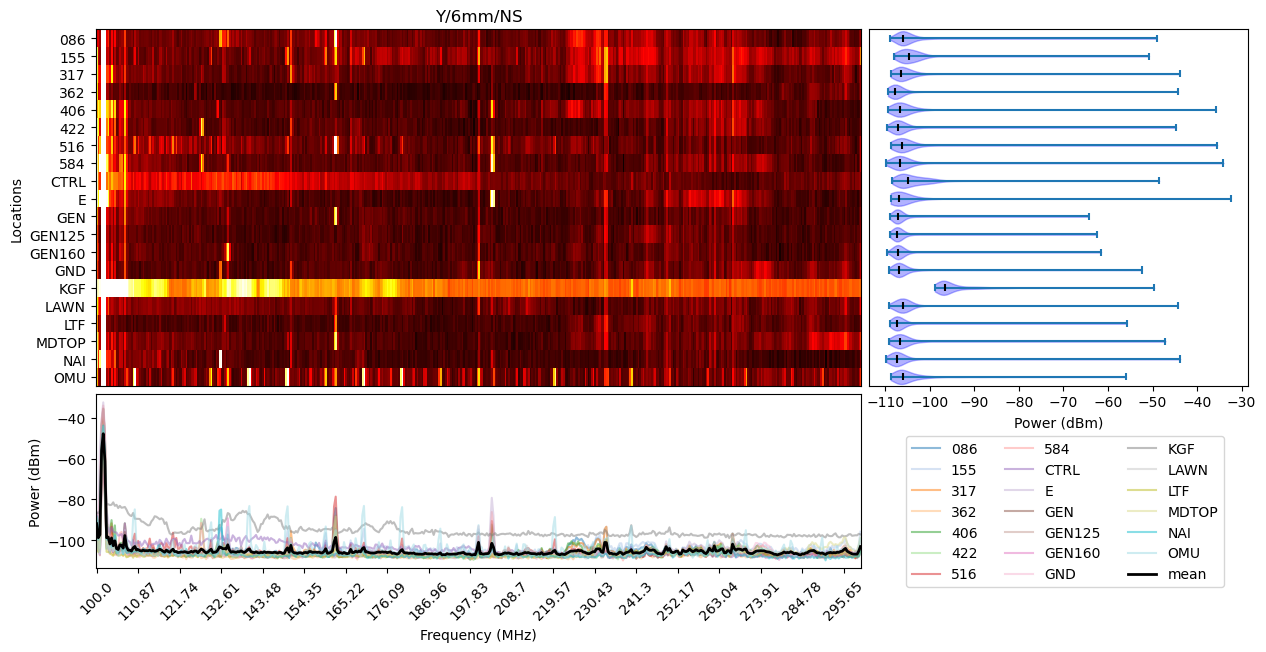

In [216]:
_, axes = plot_spectral_heatmap(YPolPwr,Frequency,YPolLocations,violin_color='blue')
axes[0].set_title('Y/6mm/NS')